# Predicting Wave Height at Chicago Beaches  

Understanding fluid dynamics is essential for water activities.  Chicago has an active sailing community offering sailboat tours, rentals and lessons.  Numerous sailing races and activities are held throughout the summer in Chicago and being able to choose the optimal weekend based on historical wave data is ideal.  

The Chicago Park District maintains sensors in Lake Michigan at 6 beaches along the lakefront.  The sensors are in operation during the summer and measurements are recorded hourly. This dataset will answer some basic questions including which beach has the largest and smallest waves? Does turbidity vary between beaches?  Does water temperature vary widely between beaches? 

This dataset was downloaded from data.world https://data.world/cityofchicago/beach-water-quality-automated-sensors. 
Source: City of Chicago https://data.cityofchicago.org/d/qmqz-2xku

## Key Terms  

Automated sensors recorded turbidity, wave height (in meters(m)), wave period (in seconds), transducer depth, and water temperature in ºC.  
**Turbidity** is the measure of relative clarity of a liquid.  
**Wave height** is the difference between elevations of a crest and a neighboring trough.  
**Transducer depth** is the depth of the sensor measured in meters.  

In [1]:
from initial_cleaning import initial_cleaning

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.mlab import PCA as mlabPCA

import warnings
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
#import datetime
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 
from datetime import datetime

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context('notebook', font_scale=1.5)

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
beach = pd.DataFrame(initial_cleaning('/Users/jamilab/Data_Science/Data_Sets/beach-water-quality-automated-sensors-1.csv'))

          Beach Name   Measurement Timestamp  Water Temperature  Turbidity  \
0     Montrose Beach  08/30/2013 08:00:00 AM             20.300      1.180   
1  Ohio Street Beach  05/26/2016 01:00:00 PM             14.400      1.230   
2      Calumet Beach  09/03/2013 04:00:00 PM             23.200      3.630   
3      Calumet Beach  05/28/2014 12:00:00 PM             16.200      1.260   
4     Montrose Beach  05/28/2014 12:00:00 PM             14.400      3.360   

   Transducer Depth  Wave Height  Wave Period  Battery Life  \
0             0.891        0.080        3.000         9.400   
1               nan        0.111        4.000        12.400   
2             1.201        0.174        6.000         9.400   
3             1.514        0.147        4.000        11.700   
4             1.388        0.298        4.000        11.900   

  Measurement Timestamp Label               Measurement ID  
0           8/30/2013 8:00 AM    MontroseBeach201308300800  
1          05/26/2016 1:00 PM 

In [3]:
beach = beach.dropna()

In [4]:
beach.isnull().sum()

Beach Name                     0
Measurement Timestamp          0
Water Temperature              0
Turbidity                      0
Transducer Depth               0
Wave Height                    0
Wave Period                    0
Battery Life                   0
Measurement Timestamp Label    0
Measurement ID                 0
dtype: int64

In [5]:
beach.shape

(10034, 10)

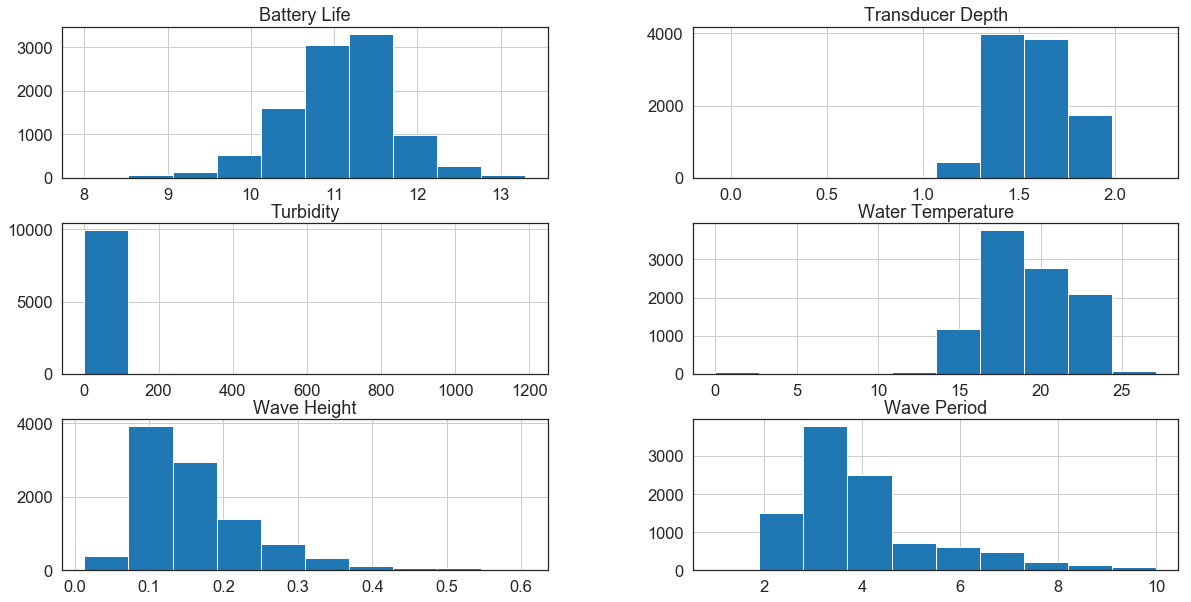

In [6]:
# Visualize the data
beach.hist()
plt.show();

## Which beaches have the largest and smallest waves?  

#### As shown in the swarm and box plots below, Montrose Beach has the largest waves.  Calumet Beach has the smallest waves.

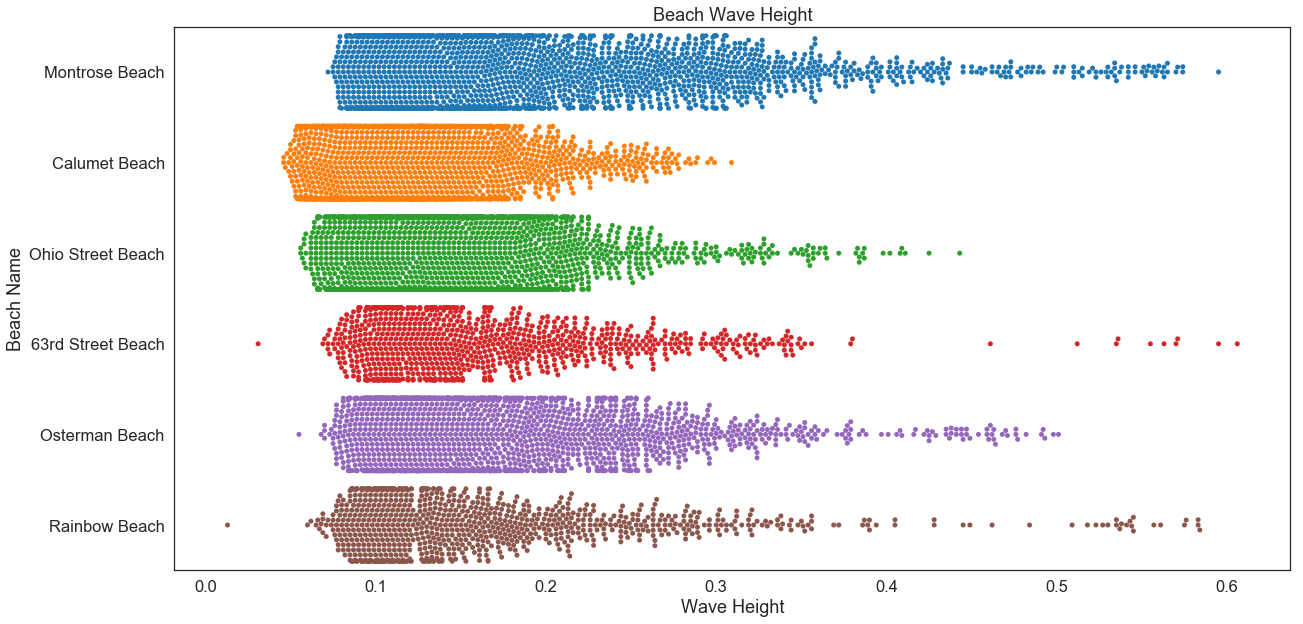

In [7]:
# wave height and beach

ax = sns.swarmplot(x='Wave Height', y='Beach Name', data=beach)
plt.title('Beach Wave Height')
ax.set(xlabel='Wave Height', ylabel='Beach Name')
plt.show();

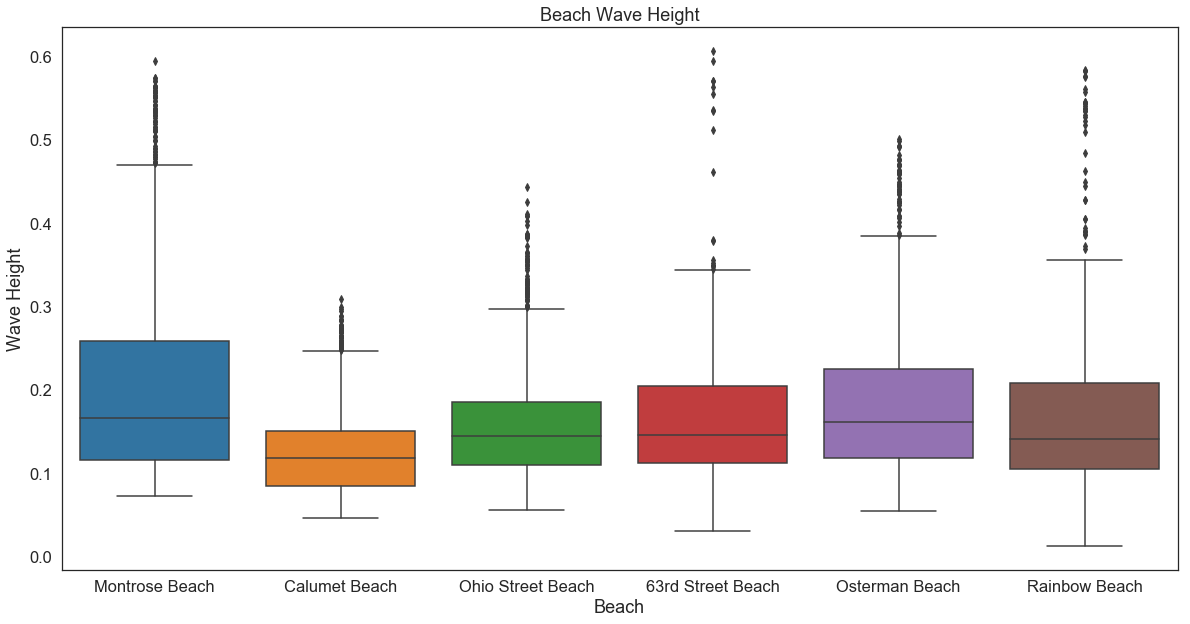

In [8]:
# wave height and beach name

ax = sns.boxplot(x='Beach Name', y='Wave Height', data=beach)
plt.title('Beach Wave Height')
ax.set(xlabel='Beach', ylabel='Wave Height')
plt.show();

## Does turbidity vary between beaches?  

#### Yes. Ohio Street Beach has the most turbid water of the 6 beaches.  This islikely due to Lake Michigan also being the main stem of the Y-shaped Chicago River.

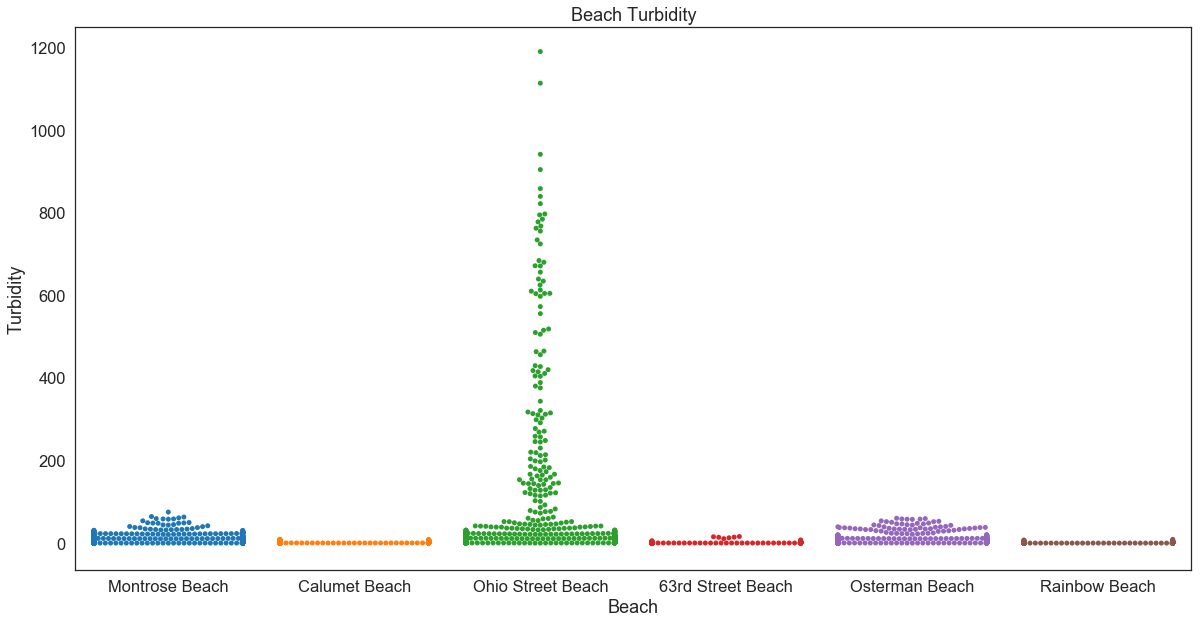

In [9]:
# turbidity and beach

ax = sns.swarmplot(x='Beach Name', y='Turbidity', data=beach)
plt.title('Beach Turbidity')
ax.set(xlabel='Beach', ylabel='Turbidity')
plt.show();

## Does water temperature vary significantly between beaches?  

#### No, water temperature doesn't vary widely betwee beaches.  The temperature appears consistent among the beaches with approximately a 3ºC difference between the highest and lowest temperatures.

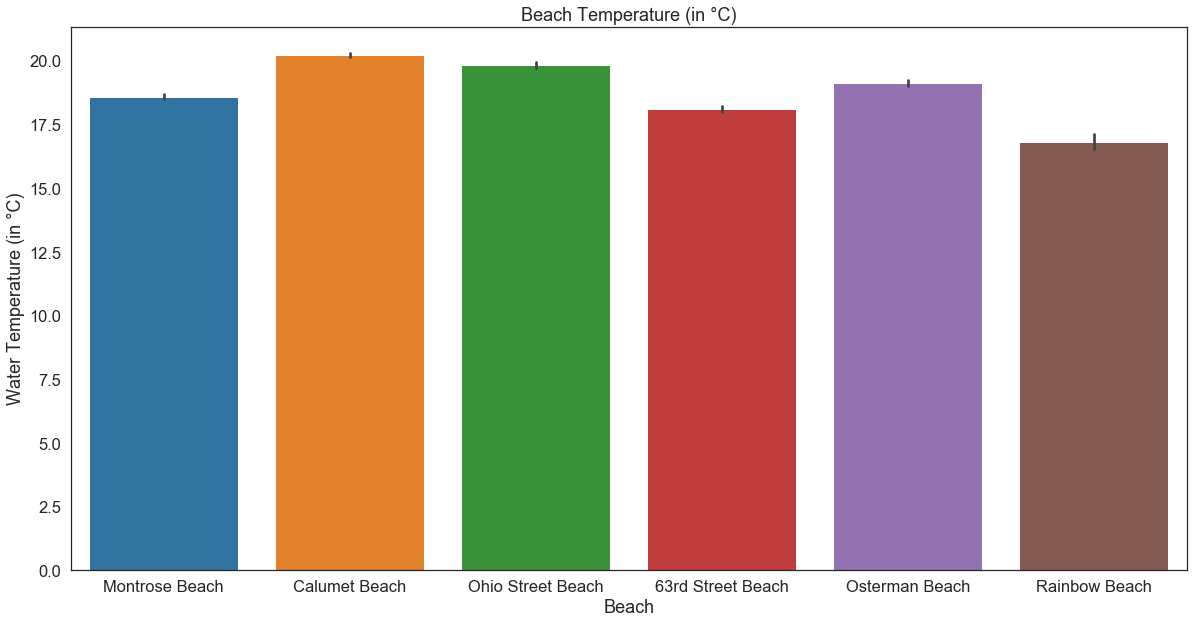

In [12]:
ax = sns.barplot(x='Beach Name', y='Water Temperature', data=beach)
plt.title('Beach Temperature (in °C)')
ax.set(xlabel='Beach', ylabel='Water Temperature (in °C)')
plt.show();

## Does wave period vary between beaches?  

#### No, wave period doesn't vary significantly between beaches.

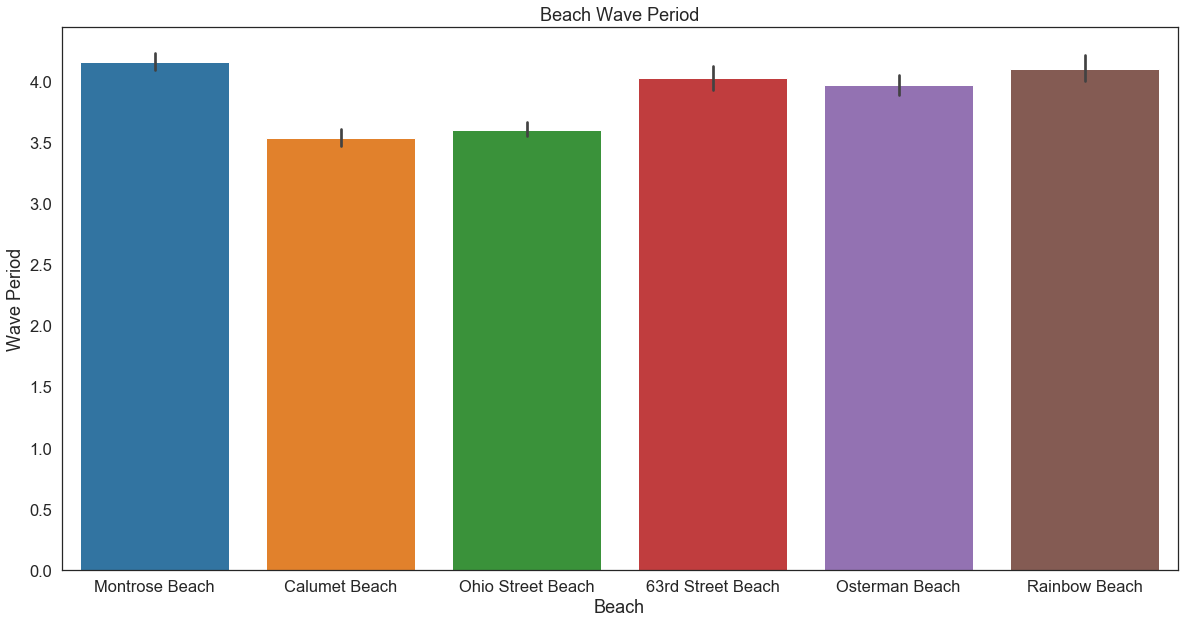

In [13]:
ax = sns.barplot(x='Beach Name', y='Wave Period', data=beach)
plt.title('Beach Wave Period')
ax.set(xlabel='Beach', ylabel='Wave Period')
plt.show();

## Does transducer depth vary between beaches?  

#### No, transducer depth does not vary widely between beaches.

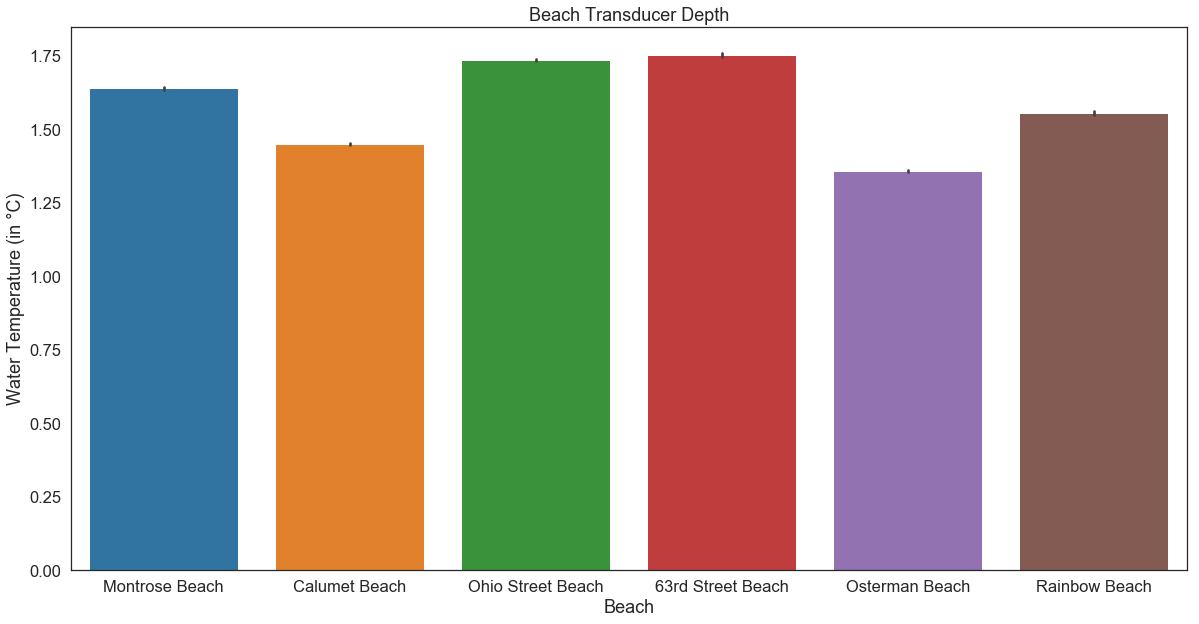

In [14]:
ax = sns.barplot(x='Beach Name', y='Transducer Depth', data=beach)  
plt.title('Beach Transducer Depth')
ax.set(xlabel='Beach', ylabel='Water Temperature (in °C)')
plt.show();

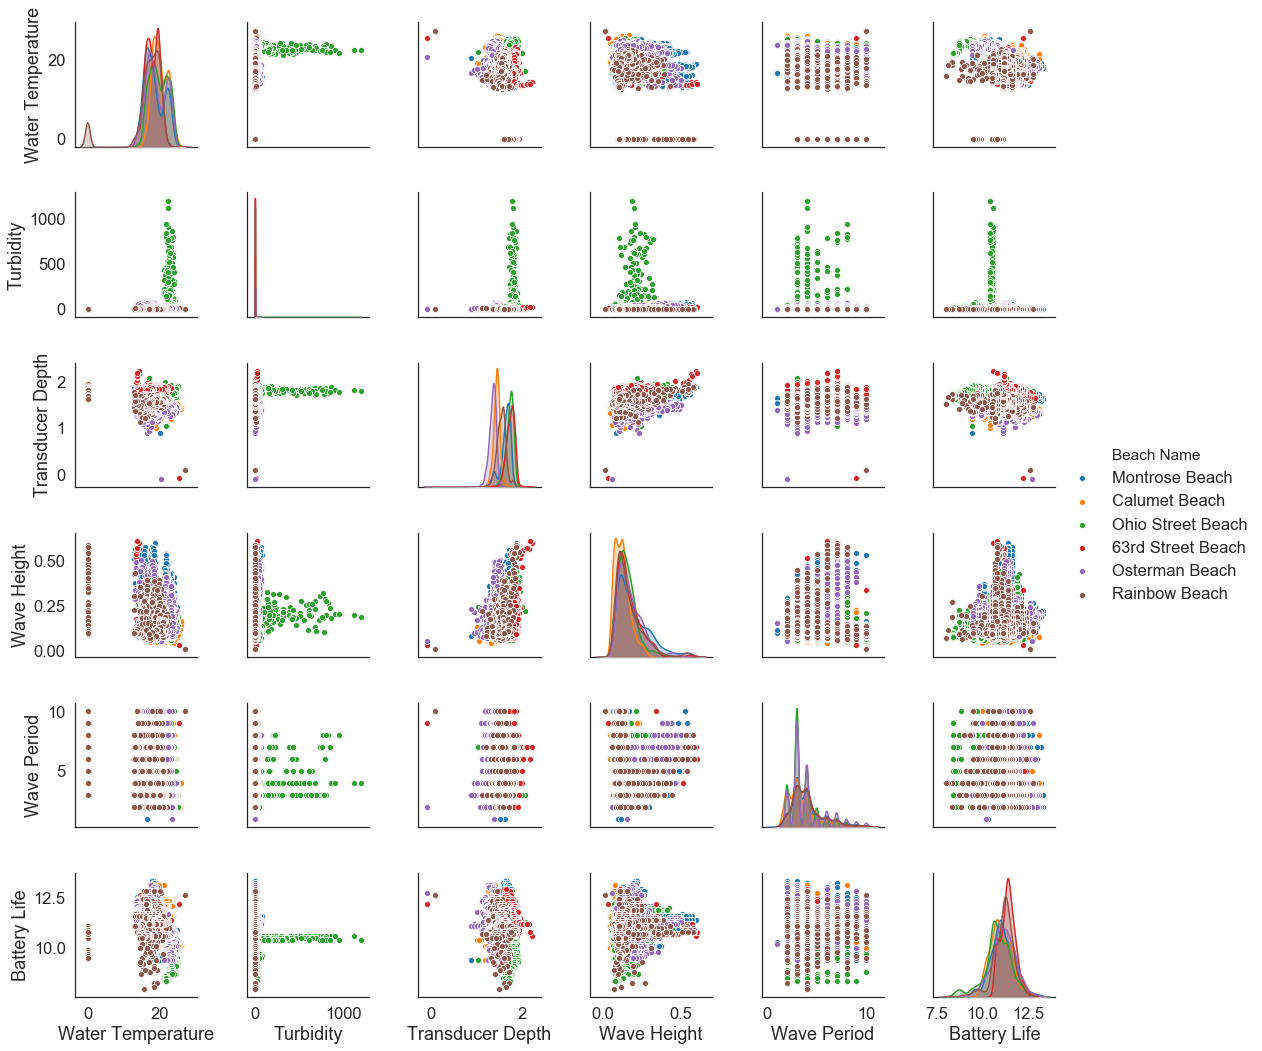

In [15]:
sns.pairplot(data=beach, hue='Beach Name');

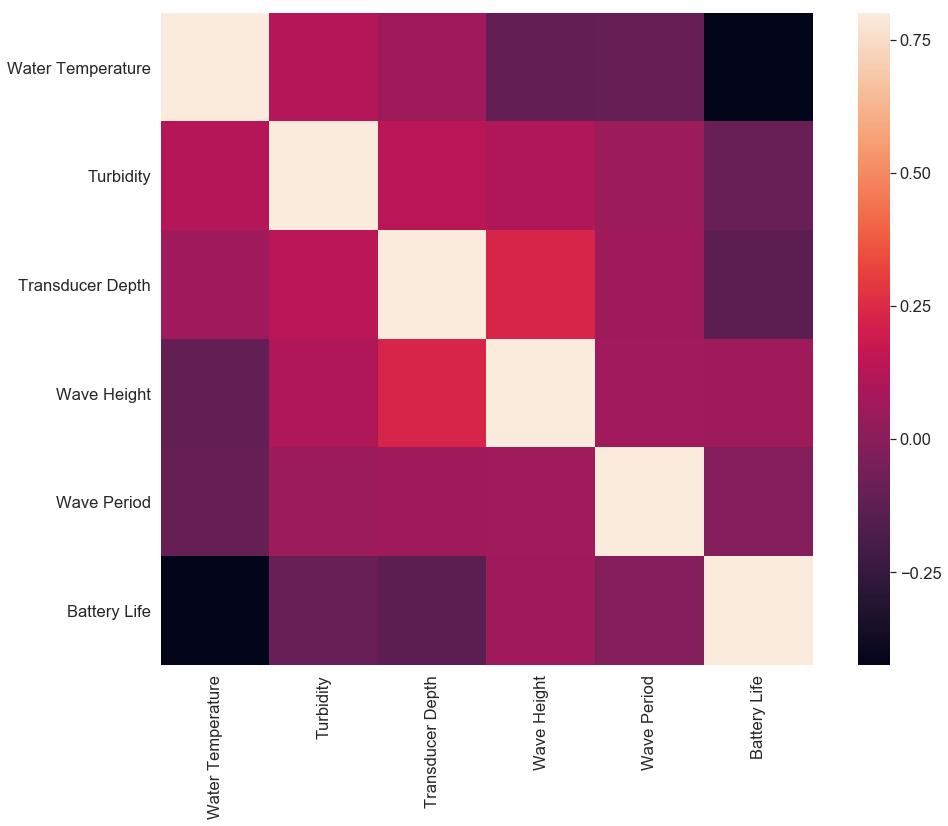

In [16]:
# correlation matrix

corrmat = beach.corr()

# Set up the matplotlib figure

f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn

sns.heatmap(corrmat, vmax=.8, square=True)
plt.show();

#print(beach.corr)

In [17]:
beach_name = pd.get_dummies(beach['Beach Name'])

In [18]:
beach = beach.drop('Beach Name', 1)

In [19]:
beach = pd.concat([beach, beach_name], axis = 1)

In [20]:
beach['Measurement Timestamp'] = pd.to_datetime(beach['Measurement Timestamp'])

In [21]:
beach['Measurement Timestamp Label'] = pd.to_datetime(beach['Measurement Timestamp Label'])

In [22]:
y = beach['Wave Height']
X = beach.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], axis=1)

In [23]:
# Divide into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# instantiate linear regression model & perform cross validation

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

print(linreg.score(X_test, y_test))

cross_val_score(linreg, X_test, y_test, cv=10)

0.221120516745


array([ 0.19121485,  0.2604086 ,  0.261584  ,  0.12540758,  0.23002681,
        0.10980925,  0.27286684,  0.22025552,  0.23197116,  0.21130986])

In [25]:
# instantiate & run random forest regression tree with 10 fold cross validation

rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)

print(rfr.score(X_test, y_test))

cross_val_score(rfr, X_test, y_test, cv=10)

0.773253792569


array([ 0.66375223,  0.77894454,  0.78982944,  0.69596587,  0.74172118,
        0.73872016,  0.68760617,  0.75171317,  0.702635  ,  0.65768913])

In [26]:
# instantiate & run ridge regression model with 10-fold cross validation

ridgereg = linear_model.Ridge(fit_intercept=False) 
ridgereg.fit(X_train, y_train)

print(ridgereg.score(X_test, y_test))

cross_val_score(ridgereg, X_test, y_test, cv=10)

0.222335555801


array([ 0.18587614,  0.25519833,  0.24671711,  0.1520698 ,  0.21377892,
        0.11567043,  0.26154424,  0.22009931,  0.22644155,  0.21544225])

In [27]:
# Build knn regression model

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

cross_val_score(knn, X_test, y_test, cv=10)

0.651094049694


array([ 0.50330137,  0.61980342,  0.66118559,  0.48080003,  0.46373414,
        0.52116807,  0.5395705 ,  0.5952821 ,  0.48778087,  0.60257407])

In [28]:
# Run the model again with weights

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X_train, y_train)

print(knn_w.score(X_test, y_test))
cross_val_score(knn_w, X_test, y_test, cv=10)

0.688517491193


array([ 0.53887504,  0.68893303,  0.69101961,  0.54933259,  0.56996962,
        0.59290071,  0.57814077,  0.63768428,  0.53798985,  0.63843274])

In [29]:
# knn cross validation for unweighted & weighted models

score = cross_val_score(knn, X_test, y_test, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, X_test, y_test, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.55 (+/- 0.13)
Weighted Accuracy: 0.60 (+/- 0.11)


## Model Evaluation   

#### Random forest regressor performed the best with a prediction accuracy of 76%, followed by weighted KNN with an accuracy of 68%.  Consistent cross validation scores suggest each model is stable.

In [30]:
# Create interactions to capture potential relationships between features

beach['water_turbidity'] = beach['Water Temperature'] * beach['Turbidity']
beach['water_transd_depth'] = beach['Water Temperature'] * beach['Transducer Depth']
beach['water_wave_period'] = beach['Water Temperature'] * beach['Wave Period']
beach['turbidity_transd_depth'] = beach['Turbidity']  * beach['Transducer Depth']
beach['turbidity_wave_period'] = beach['Turbidity'] * beach['Wave Period']
beach['trans_depth_wave_period'] = beach['Transducer Depth'] * beach['Wave Period']

In [41]:
# create a dataframe to hold features

features = pd.concat([beach.copy()], axis = 1)

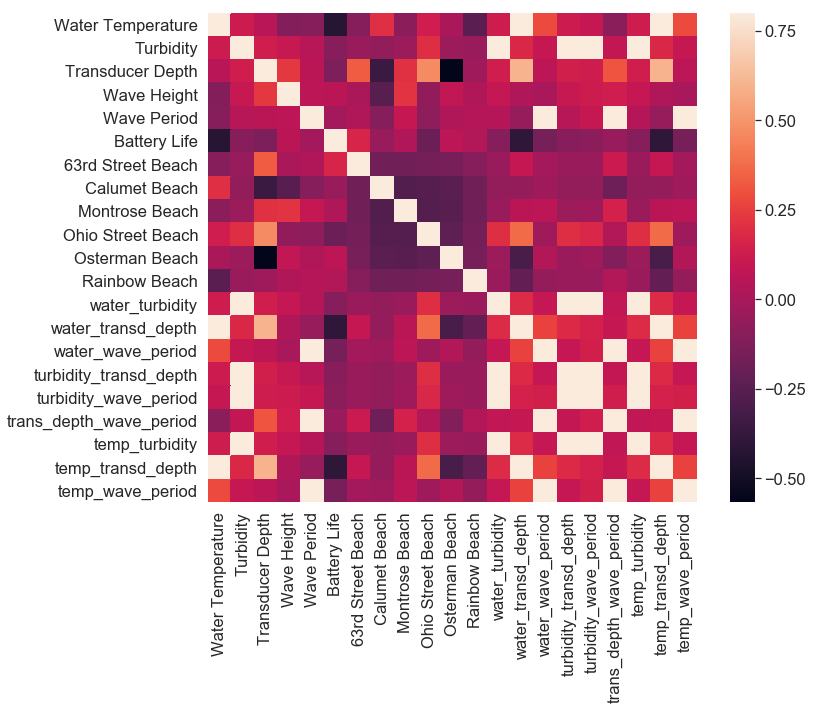

In [43]:
# view a correlation matrix to determine collinearity, if any

corrmat = features.corr()

# Set up the matplotlib figure.

f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn

sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [44]:
means = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']].mean(axis=0)
stds = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']].std(axis=0)
features['transd_wave_turbid'] = ((features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 
                                             'temp_wave_period']] - means) / stds).mean(axis=1)

# Check how well the composite correlates with each individual variable

plotdf = features.loc[:, ['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]
plotdf['transd_wave_turbid'] = features['transd_wave_turbid'] 
corrmat2 = plotdf.corr()

print(corrmat2)

                        Turbidity  turbidity_transd_depth  \
Turbidity                   1.000                   1.000   
turbidity_transd_depth      1.000                   1.000   
turbidity_wave_period       0.935                   0.934   
temp_wave_period            0.095                   0.094   
transd_wave_turbid          0.940                   0.939   

                        turbidity_wave_period  temp_wave_period  \
Turbidity                               0.935             0.095   
turbidity_transd_depth                  0.934             0.094   
turbidity_wave_period                   1.000             0.139   
temp_wave_period                        0.139             1.000   
transd_wave_turbid                      0.933             0.412   

                        transd_wave_turbid  
Turbidity                            0.940  
turbidity_transd_depth               0.939  
turbidity_wave_period                0.933  
temp_wave_period                     0.412  
trans

In [45]:
# change 0ºC to .001º to avoid 0 division error 

beach['Water Temperature'] = beach['Water Temperature'].replace(0, 0.001, regex=True)

In [31]:
del X_train
del X_test
del y_train
del y_test

In [32]:
y = beach['Wave Height']
X = beach.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], axis=1)

In [33]:
# Divide into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
# instantiate linear regression model & perform cross validation

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

print(linreg.score(X_test, y_test))

cross_val_score(linreg, X_test, y_test, cv=10)

0.336419129202


array([ 0.22613057,  0.42881129,  0.43109503,  0.25432261,  0.37846221,
        0.26336911,  0.27042833,  0.4028424 ,  0.29294954,  0.29207083])

In [35]:
# instantiate & run regression tree with 10 fold cross validation

rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)

print(rfr.score(X_test, y_test))

cross_val_score(rfr, X_test, y_test, cv=10)

0.756659555921


array([ 0.63905096,  0.73920087,  0.74735776,  0.66894616,  0.73156773,
        0.70923703,  0.65402413,  0.68685883,  0.69403651,  0.65000245])

In [36]:
# instantiate & run ridge regression for feature engineered data with 10 fold cross validation

ridgereg = linear_model.Ridge()
ridgereg.fit(X_train, y_train)

print('\nFeature engineered data:')
print(ridgereg.score(X_test, y_test))

cross_val_score(ridgereg, X_test, y_test, cv=10)


Feature engineered data:
0.333901791881


array([ 0.23340879,  0.43181132,  0.42308991,  0.24450505,  0.38004654,
        0.18346871,  0.26205258,  0.39841593,  0.29102316,  0.3050708 ])

In [37]:
# Build knn regression model

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))

cross_val_score(knn, X_test, y_test, cv=10)

0.531307261492


array([ 0.43515392,  0.51782913,  0.58512583,  0.3245834 ,  0.3629865 ,
        0.42641663,  0.43937667,  0.56188036,  0.42603293,  0.52887922])

In [38]:
# Run the model again with weights

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X_train, y_train)

print(knn_w.score(X_test, y_test))
cross_val_score(knn_w, X_test, y_test, cv=10)

0.554628755515


array([ 0.44742558,  0.56675375,  0.59837327,  0.32602533,  0.43044077,
        0.48372921,  0.45356334,  0.59230008,  0.41939641,  0.5491859 ])

In [39]:
# knn cross validation for unweighted & weighted models

score = cross_val_score(knn, X_test, y_test, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, X_test, y_test, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.46 (+/- 0.16)
Weighted Accuracy: 0.49 (+/- 0.17)


## Model Evaluation  

#### After creating interactions, linear regression and ridge regression improved although the scores remained unacceptably low.  Random forest performed roughly the same with 76% accuracy.  Both the weighted and unweighted KNN models performed worse after creating interactions with approximately a  13% decrease in accuracy.

## Feature Importance  

#### Random forest identified turbidity_transd_depth, Ohio Street Beach and transducer_depth as the top 3 features affecting prediction accuracy.

                         importance
Feature                            
turbidity_transd_depth        0.247
Ohio Street Beach             0.119
Transducer Depth              0.104
turbidity_wave_period         0.097
Battery Life                  0.079
Water Temperature             0.057
water_wave_period             0.056
water_transd_depth            0.054
trans_depth_wave_period       0.049
Turbidity                     0.039
water_turbidity               0.034
Calumet Beach                 0.021
Wave Period                   0.015
Rainbow Beach                 0.013
63rd Street Beach             0.009
Montrose Beach                0.005
Osterman Beach                0.002


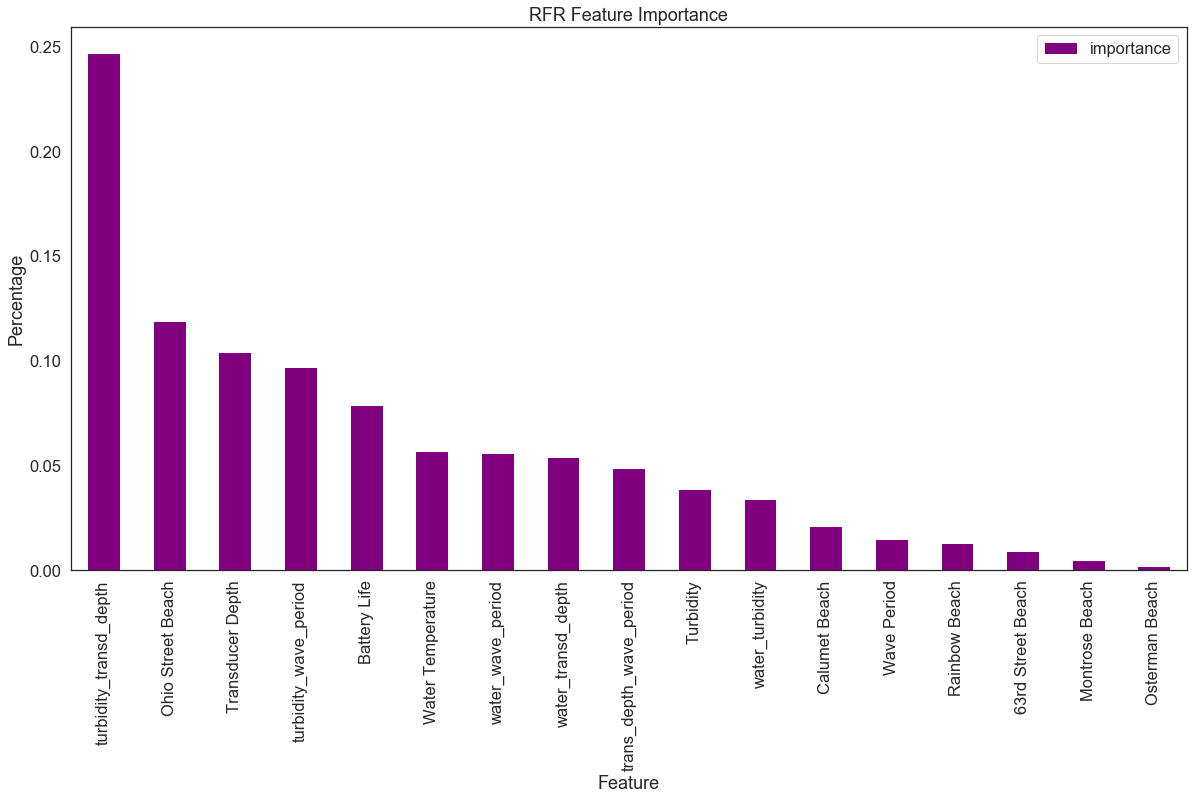

In [40]:
# rfr feature importance

importances = pd.DataFrame({'Feature':X_train.columns,'importance':np.round(rfr.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('Feature')
 
print(importances[:20])
importances[:20].plot.bar(color='purple')
plt.title('RFR Feature Importance')
plt.ylabel('Percentage');

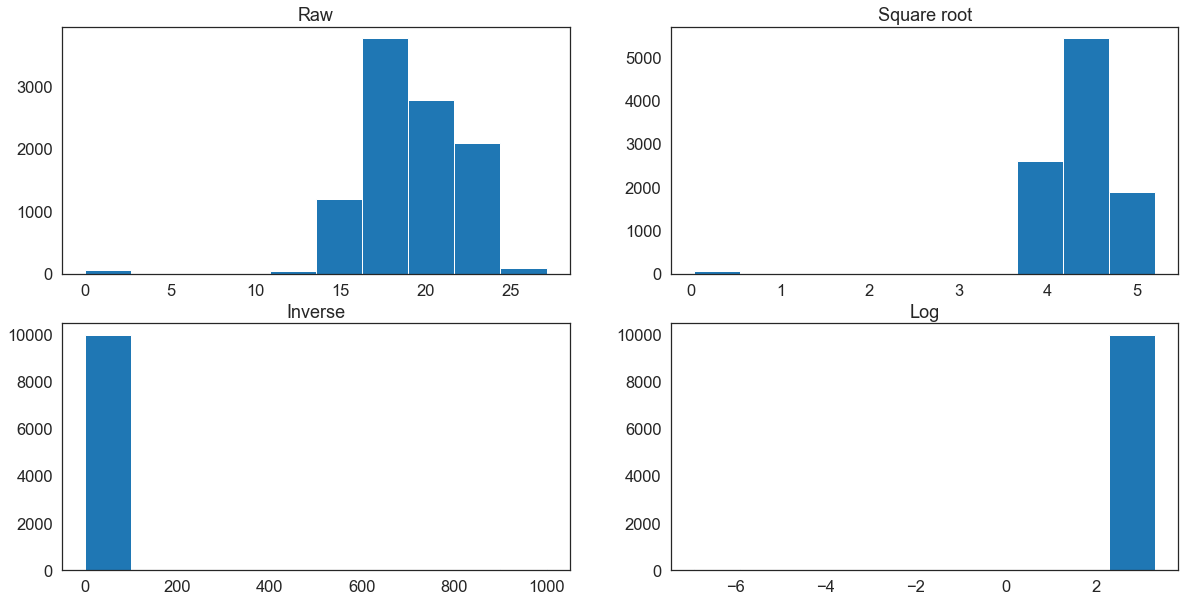

In [46]:
# Using water temperature since it's less highly correlated to the other features to create a transformation on.
# Four-panel plot

fig = plt.figure()

fig.add_subplot(221)
plt.hist(beach['Water Temperature'])
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.sqrt(beach['Water Temperature']))
plt.title('Square root')

fig.add_subplot(223)
plt.hist(1/beach['Water Temperature'])
plt.title('Inverse')

ax3=fig.add_subplot(224)
plt.hist(np.log(beach['Water Temperature']))
plt.title('Log')
plt.show()

# Create a transformation using square root, since it's the most approximately normal of the 3

features['sqrt_temp'] = (np.sqrt(beach['Water Temperature']))

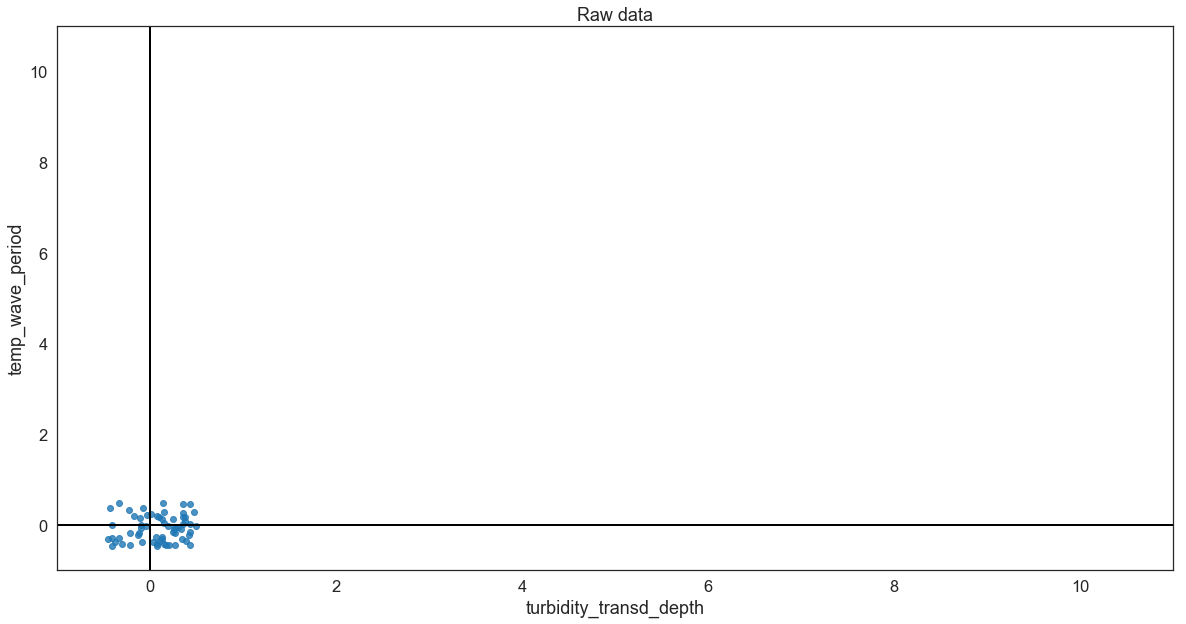

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


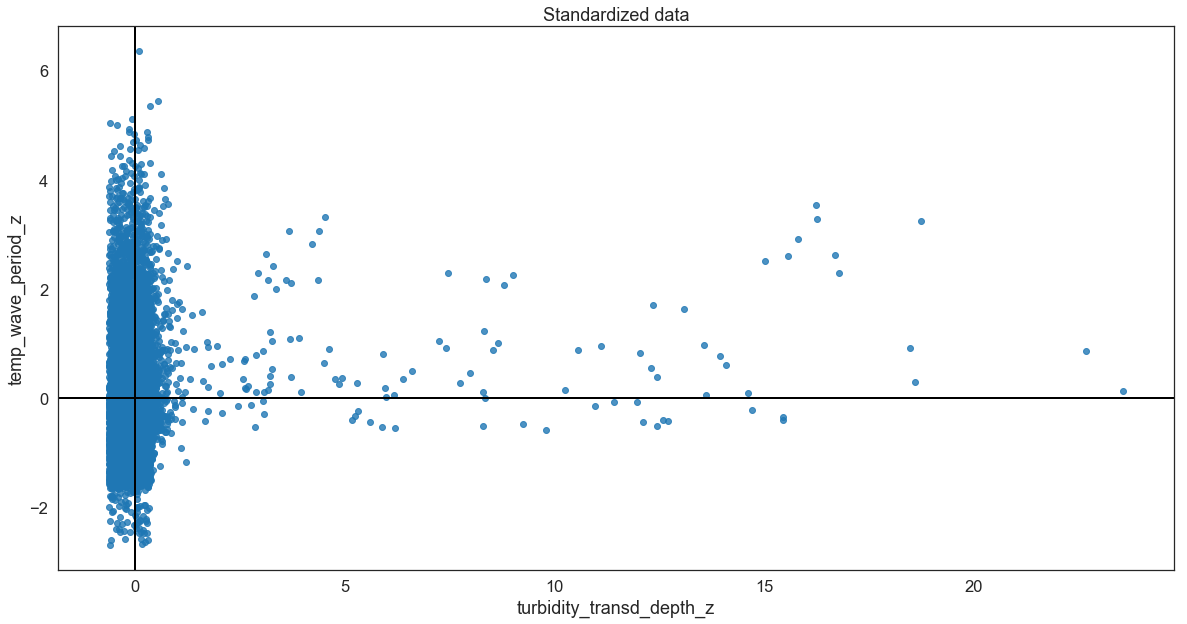

In [47]:
# calculating PCA by hand
# Make the scatterplot matrix. Take a subset of the data for PCA. 

df_pca = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]

t = sns.regplot(
    'turbidity_transd_depth',
    'temp_wave_period',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard deviation. 

df_pca['turbidity_transd_depth_z'] = (df_pca['turbidity_transd_depth'] - df_pca['turbidity_transd_depth'].mean()) / df_pca['turbidity_transd_depth'].std()
df_pca['temp_wave_period_z'] = (df_pca['temp_wave_period'] - df_pca['temp_wave_period'].mean()) / df_pca['temp_wave_period'].std()

t = sns.regplot(
    'turbidity_transd_depth_z',
    'temp_wave_period_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


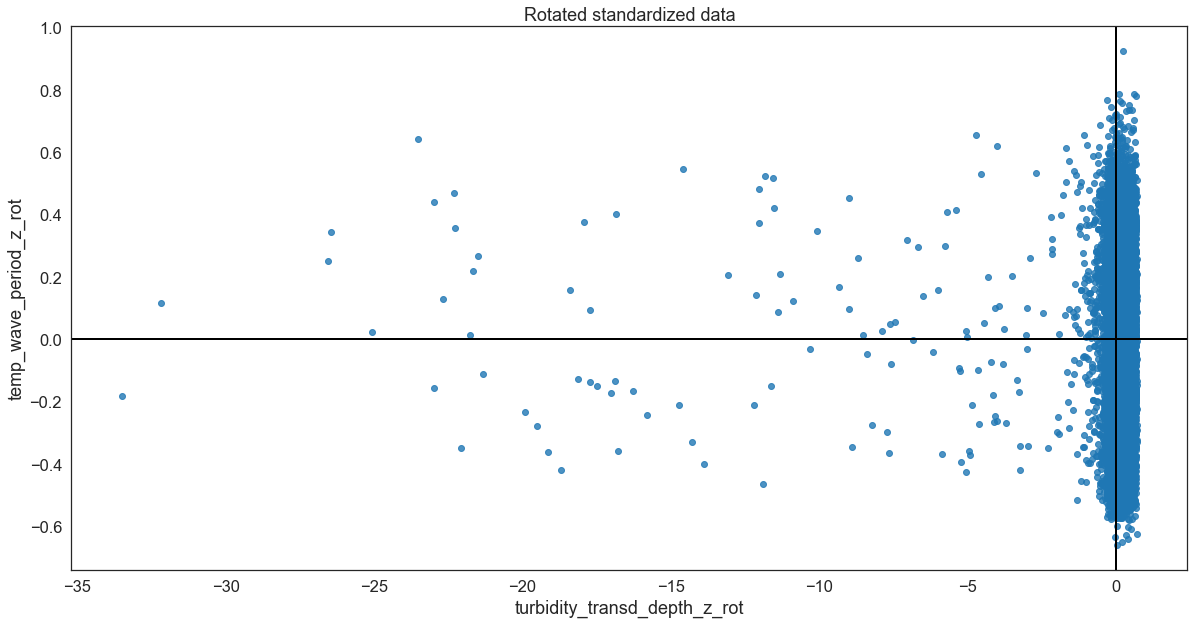

In [48]:
# Rotating the data so that the axes roughly match to vector above

df_pca['turbidity_transd_depth_z_rot'] = math.cos(40) * df_pca['turbidity_transd_depth_z'] - math.sin(40) * df_pca['turbidity_transd_depth_z']
df_pca['temp_wave_period_z_rot'] = math.sin(40) * df_pca['temp_wave_period_z'] + math.cos(40) * df_pca['temp_wave_period_z']

t = sns.regplot(
    'turbidity_transd_depth_z_rot',
    'temp_wave_period_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()



In [49]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1

X = StandardScaler().fit_transform(df_pca)

# NumPy covariance function assumes variables are represented by rows, not columns, so transpose X

Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00009967  0.99971266  0.93508951  0.09547065  0.99971266  0.09547065
  -0.99971266  0.09547065]
 [ 0.99971266  1.00009967  0.93389446  0.09374247  1.00009967  0.09374247
  -1.00009967  0.09374247]
 [ 0.93508951  0.93389446  1.00009967  0.13912459  0.93389446  0.13912459
  -0.93389446  0.13912459]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]
 [ 0.99971266  1.00009967  0.93389446  0.09374247  1.00009967  0.09374247
  -1.00009967  0.09374247]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]
 [-0.99971266 -1.00009967 -0.93389446 -0.09374247 -1.00009967 -0.09374247
   1.00009967 -0.09374247]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]]


In [50]:
# Calculating eigenvalues and eigenvectors

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspect eigenvalues and eigenvectors

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 8).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.44137499+0.j]
 [-0.44122220+0.j]
 [-0.42668008+0.j]
 [-0.11416530+0.j]
 [-0.44122220+0.j]
 [-0.11416530+0.j]
 [ 0.44122220+0.j]
 [-0.11416530+0.j]]
Eigenvalue 1: (4.976239375242475+0j)
----------------------------------------
Eigenvector 2: 
[[-0.09412967+0.j]
 [-0.09513361+0.j]
 [-0.06162129+0.j]
 [ 0.56574176+0.j]
 [-0.09513361+0.j]
 [ 0.56574176+0.j]
 [ 0.09513361+0.j]
 [ 0.56574176+0.j]]
Eigenvalue 2: (2.921970277125387+0j)
----------------------------------------
Eigenvector 3: 
[[-0.20651749+0.j]
 [-0.21800379+0.j]
 [ 0.90225623+0.j]
 [-0.01535429+0.j]
 [-0.21800379+0.j]
 [-0.01535429+0.j]
 [ 0.21800379+0.j]
 [-0.01535429+0.j]]
Eigenvalue 3: (0.10201953876083661+0j)
----------------------------------------
Eigenvector 4: 
[[ -8.68146446e-01+0.j]
 [  2.86496515e-01+0.j]
 [  8.97846209e-03+0.j]
 [  3.54266347e-04+0.j]
 [  2.86496515e-01+0.j]
 [  3.54266347e-04+0.j]
 [ -2.86496515e-01+0.j]
 [  3.54266346e-04+0.j]]
Eigenvalue 4: (0.0005681775546431786+0j)
-------

**Component 1 and 2 at 62% & 36% respectively, account for approximately 98% of the variance in the dataset.** 

/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


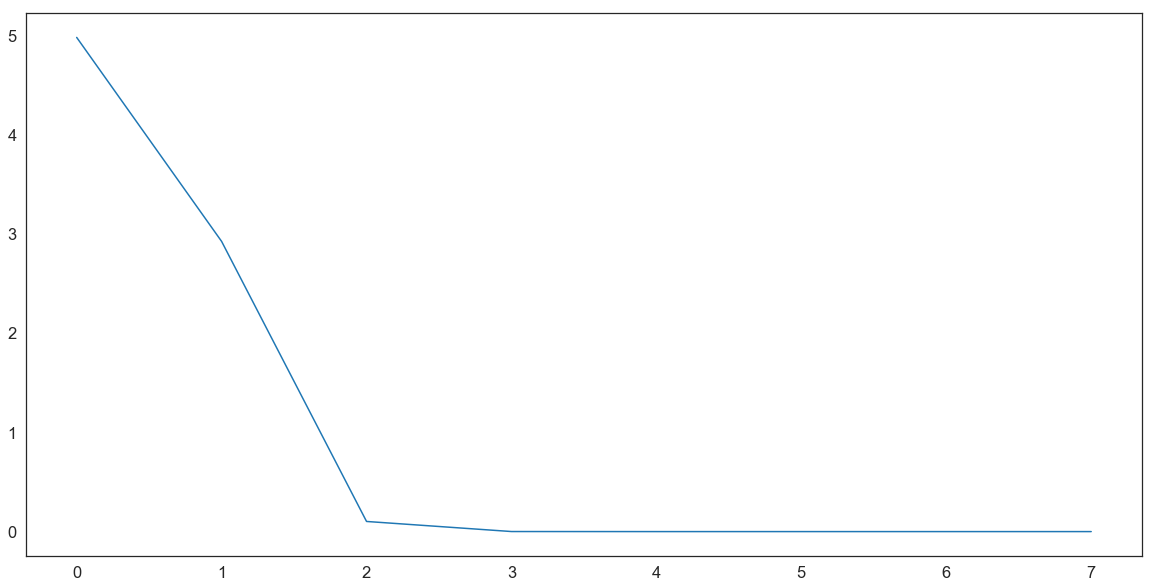

In [51]:
plt.plot(eig_val_cov)
plt.show()

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/jamilab/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


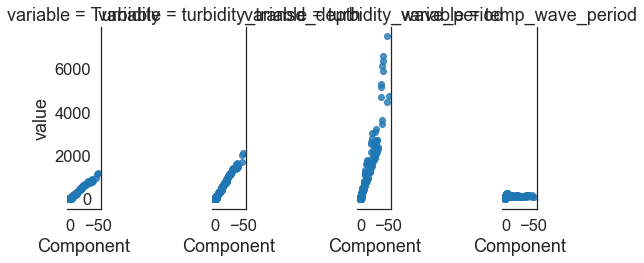

In [52]:
# Create P, which we will use to transform Cx into Cy to get Y, the dimensionally-reduced representation of X.

P = eig_vec_cov[:, 0]

# Transform X into Y

Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.

data_to_plot = df_pca[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

The percentage of total variance in the dataset explained by each component.
 [  6.21967930e-01   3.65209884e-01   1.27511714e-02   7.10151162e-05]


/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


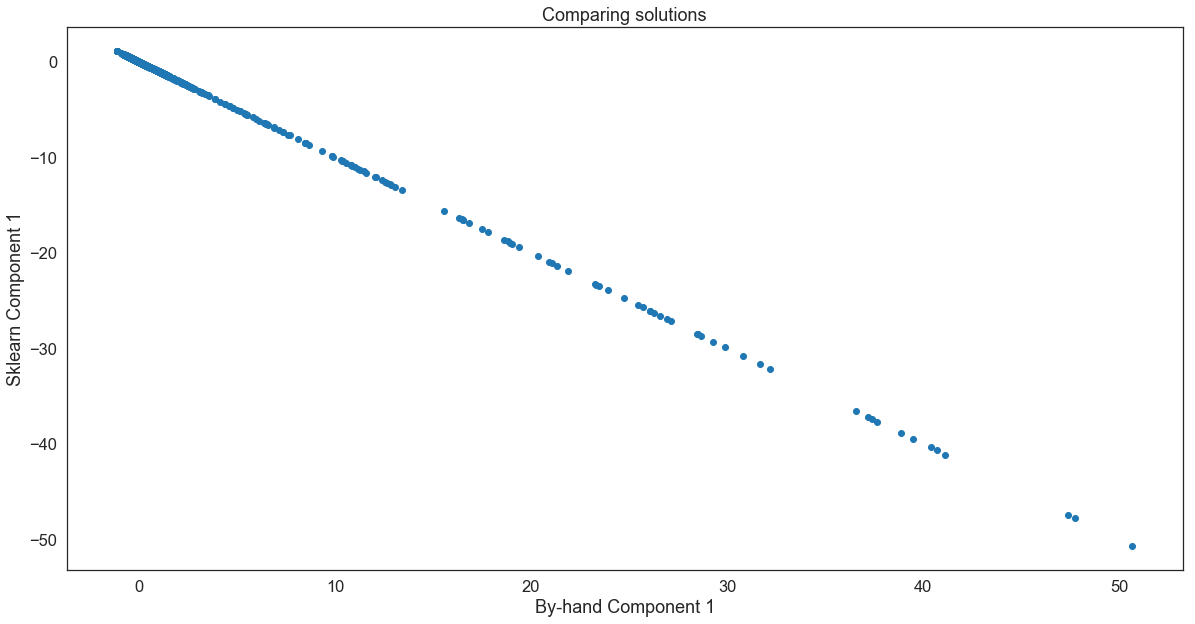

In [53]:
# PCA using skLearn

sklearn_pca = PCA(n_components=4)
y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each component.\n',
    sklearn_pca.explained_variance_ratio_
)

Runtime for k-means:
0:00:00.000156


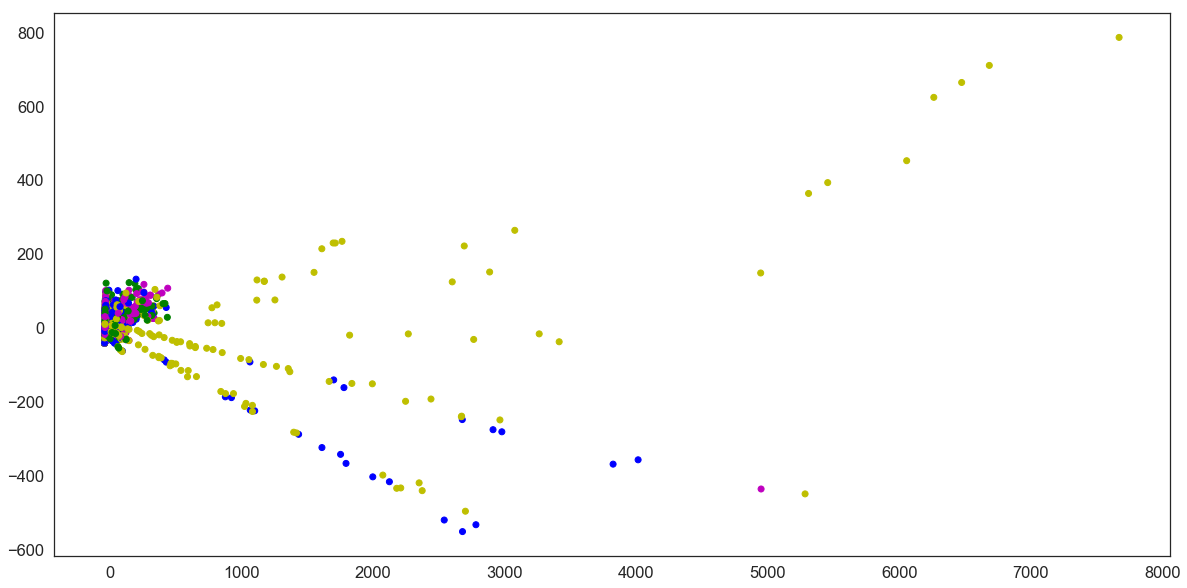

In [54]:
# K-Means
# Define the features and the outcome.
X = df_pca

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X)

# Calculate predicted values.
km = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)

startTime = datetime.now()
print('Runtime for k-means:')
print(datetime.now() - startTime)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='mybg')
plt.show()

In [66]:
correct = 0
for i in range(len(X_pca)):
    predict_me = np.array(X_pca[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = km.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X_pca))

NameError: name 'predict' is not defined

In [59]:
# map kmeans clusters to find out what the clusters represent

import numpy as np
X = np.array([[0, 1], [2, 3]])
for i in range(100):
    kmeans = KMeans(n_clusters=2, random_state=i).fit(X)
    print(kmeans.cluster_centers_)

[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 2.  3.]
 [ 0.  1.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]
 [ 2.  3.]]
[[ 0.  1.]


In [57]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

pd.crosstab(y, full_pred) 

col_0,0,1
Wave Height,,
0.013,1,0
0.031,1,0
0.046,2,0
0.047,1,0
0.048,1,0
0.049,2,0
0.050,4,0
0.051,2,0
0.052,5,0


In [58]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

4.0097870493693383e-05

Model Performance
Running the data through a pipeline seems to combat overfitting observed when running each model separately. The random forest pipeline performed well, however xgboost and knn both performed better. KNN had higher accuracy and shorter fit time than xgboost. The knn pipelineis the most efficient, and should be tested in a production environment to verify performance.
Business Recommendations
Month to month contracts are identified as a significant feature in predicting churn. Eliminate month to month contracts to improve customer retention.
Women churn earlier than men, so targeted incentives to maintain the female customer base should be considered and explored.
Additionally, a significant number of customers churn between 5-6 years, so customer loyalty bonuses or incentives could help retain customers ready to churn.